# Wstęp
Zadanie 10 stanowi drugi z trzech etapów zajęć poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem wszystkich trzech etapów będzie sieć rekurencyjna z warstwą atencji do predykcji kursu kryptowaluty [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji 
2.   MultiBTC - multimodalny model sieci rekurencyjnej do predykcji kursu BTC
3.   AttEmoTweet & AttMultiBTC - rozszerzenie modeli EmoTweet i MultiBTC o warstwę atencji 

Każdy etap jest traktowany jako oddzielna lista na laboratorium, za którą można otrzymać 10 punktów. 

# Cel ćwiczenia

Celem drugiego etapu prac jest wykorzystanie sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji. Dopuszczalne jest rozwiązanie, które działa podobnie jak klasyfikator z poprzedniego zadania, przy czym w tym wypadku skonstruowany zostanie regresor, a zmienną predykowaną będzie np. średni kurs w następnym dniu pod warunkiem obserwacji z dni poprzednich. 

# Warunki zaliczenia

Do zaliczenia drugiego etapu należy wykonać następujące kroki:

1.   Klasyfikacja zbioru tweetów przy pomocy 2 modeli EmoTweet opracowanych w etapie nr 1 (gdyby sieci LSTM były zbyt wolne, można użyć modeli opartych o fastText).
2.   Przygotowanie modelu LSTM, dla którego każdy element sekwencji będzie multimodalny, tj. będzie opisany cechami pochodzącymi z różnych źródeł:
   * Dane z giełdy kryptowalutowej
   * Zagregowane wartości emocji z tweetów
3.   Trenowanie modelu oraz ewaluacja predykcji dla scenariusza godzinnego oraz dziennego, z uwzględnieniem wpływu:
 * wybranych hiperparametrów 
 * dodatkowych kroków wstępnego przetwarzania danych
 * wymiarów afektywnych

# Zbiór tweetów

Zbiór tweetów pochodzi z serwisu [Twitter](https://twitter.com/) i jest podzbiorem 2 milionów wiadomości dotyczących [Bitcoina](https://en.wikipedia.org/wiki/Bitcoin) z okresu od stycznia 2018 do maja 2020 roku. 
## Pobranie

In [ ]:
!wget http://jankocon.clarin-pl.eu/share/bitcoin_tweets_2M.csv.7z

--2021-05-19 18:54:24--  http://jankocon.clarin-pl.eu/share/bitcoin_tweets_2M.csv.7z
Resolving jankocon.clarin-pl.eu (jankocon.clarin-pl.eu)... 156.17.135.34
Connecting to jankocon.clarin-pl.eu (jankocon.clarin-pl.eu)|156.17.135.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97590055 (93M) [application/x-7z-compressed]
Saving to: ‘bitcoin_tweets_2M.csv.7z’

bitcoin_tweets_2M.c 100%[===================>]  93.07M  1.28KB/s    in 59s     

2021-05-19 18:55:23 (1.59 MB/s) - ‘bitcoin_tweets_2M.csv.7z’ saved [97590055/97590055]



## Rozpakowanie

In [ ]:
!7za x bitcoin_tweets_2M.csv.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 97590055 bytes (94 MiB)

Extracting archive: bitcoin_tweets_2M.csv.7z
--
Path = bitcoin_tweets_2M.csv.7z
Type = 7z
Physical Size = 97590055
Headers Size = 146
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      3% - bitcoin_tweets_2M.csv                              7% - bitcoin_tweets_2M.csv                             11% - bitcoin_tweets_2M.csv                             15% - bitcoin_tweets_2M.csv                             19% - bitcoin_tweets_2M.csv  

## Zawartość
Dane zawierają następujące kolumny:
* `timestamp` - data wysłania wiadomości
* `likes` - liczba polubień wiadomości
* `retweets` - liczba przekazań dalej wiadomości
* `username` - nick użytkownika
* `text` - tekst tweeta "zanonimizowany" przy pomocy metody [`preprocess`](https://github.com/cardiffnlp/tweeteval/blob/main/TweetEval_Tutorial.ipynb), która była użyta przy tworzeniu zbioru [TweetEval](https://github.com/cardiffnlp/tweeteval)

In [ ]:
import pandas as pd
tweets_data = pd.read_csv('bitcoin_tweets_2M.csv')
tweets_data

,timestamp,likes,retweets,username,text
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i..."
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...
...,...,...,...,...,...
2454286,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ..."
2454287,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...
2454288,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...
2454289,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...


# Dane z giełdy [Bitstamp](https://www.bitstamp.net/)
Zbiór pochodzi z serwisu Bitstamp i zawiera informacje o kursie Bitcoina od stycznia 2017 roku do kwietnia 2021 roku, zarówno w interwałach jednodniowych (24h), jak też godzinowych (1h).

## Pobranie 


In [ ]:
!wget http://jankocon.clarin-pl.eu/share/bitstamp.7z

--2021-05-19 18:55:35--  http://jankocon.clarin-pl.eu/share/bitstamp.7z
Resolving jankocon.clarin-pl.eu (jankocon.clarin-pl.eu)... 156.17.135.34
Connecting to jankocon.clarin-pl.eu (jankocon.clarin-pl.eu)|156.17.135.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773846 (756K) [application/x-7z-compressed]
Saving to: ‘bitstamp.7z’

bitstamp.7z         100%[===================>] 755.71K   178KB/s    in 4.8s    

2021-05-19 18:55:41 (158 KB/s) - ‘bitstamp.7z’ saved [773846/773846]



## Rozpakowanie

In [ ]:
!7za x bitstamp.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 773846 bytes (756 KiB)

Extracting archive: bitstamp.7z
--
Path = bitstamp.7z
Type = 7z
Physical Size = 773846
Headers Size = 221
Method = LZMA2:3m
Solid = +
Blocks = 1

  0%    Everything is Ok

Files: 2
Size:       3036393
Compressed: 773846


## Zawartość
Kwoty są podane w dolarach amerykańskich (kurs BTC/USD). Daty wyznaczają moment zamknięcia, a momentem otwarcia jest godzina wstecz (wariant 1h) lub dzień wstecz (wariant 24h). Każdy ze zbiorów zawiera następujące kolumny:
* `timestamp` - data w [formacie Unix](https://www.epochconverter.com/) 
* `date` - j.w. w formacie YYYY-MM-DD HH:MM:SS
* `open` - kurs otwarcia 
* `high` - najwyższa wartość 
* `low` - najniższa wartość 
* `close` - kurs zamknięcia
* `volume` - wolumen obrotu BTC

Interwał godzinowy:



In [ ]:
bitstamp_data_1h = pd.read_csv('Bitstamp_BTCUSD_1h_2017_2018_2019_2020_2021-04-08.csv')
bitstamp_data_1h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,966.99,964.60,966.60,102.484806
1,1483232400,2017-01-01 01:00:00,966.60,966.60,962.54,963.87,149.025554
2,1483236000,2017-01-01 02:00:00,964.35,965.75,961.99,963.97,94.267396
3,1483239600,2017-01-01 03:00:00,963.88,964.71,960.53,962.83,77.619667
4,1483243200,2017-01-01 04:00:00,960.61,963.64,960.60,963.46,46.810220
...,...,...,...,...,...,...,...
37387,1617822000,2021-04-07 19:00:00,55832.62,56127.66,55441.93,56127.66,289.995730
37388,1617825600,2021-04-07 20:00:00,56075.95,56242.37,55690.00,56204.82,175.990086
37389,1617829200,2021-04-07 21:00:00,56243.09,56401.40,56053.20,56199.64,281.857236
37390,1617832800,2021-04-07 22:00:00,56160.72,56549.00,56111.13,56449.54,117.778871


Interwał dzienny:

In [ ]:
bitstamp_data_24h = pd.read_csv('Bitstamp_BTCUSD_24h_2017_2018_2019_2020_2021-04-08.csv')
bitstamp_data_24h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,1005.00,960.53,997.75,6850.593309
1,1483315200,2017-01-02 00:00:00,997.75,1032.00,990.01,1012.54,8167.381030
2,1483401600,2017-01-03 00:00:00,1011.44,1039.00,999.99,1035.24,9089.658025
3,1483488000,2017-01-04 00:00:00,1035.51,1139.89,1028.56,1114.92,21562.456972
4,1483574400,2017-01-05 00:00:00,1114.38,1136.72,885.41,1004.74,36018.861120
...,...,...,...,...,...,...,...
1553,1617408000,2021-04-03 00:00:00,58967.61,59801.39,56922.00,57064.42,1663.268353
1554,1617494400,2021-04-04 00:00:00,57064.13,58501.00,56466.25,58212.18,1440.631820
1555,1617580800,2021-04-05 00:00:00,58213.69,59280.00,56800.00,59125.00,2402.437135
1556,1617667200,2021-04-06 00:00:00,59135.36,59473.90,57216.00,58018.30,2711.397847


# Realizacja zadania

Szczegółowa realizacja zadania powinna zawierać następujące etapy:

## Przygotowanie danych


1.   Wykorzystać modele utworzone w etapie 1 do opisania wymiarami afektywnymi (ZJAWISKO_1 oraz ZJAWISKO_2) zbioru tweetów `tweets_data`.
2.   Wyodrębnić podzbiór danych `bitstamp_data_*` z okresu dla którego są dostępne tweety.
3.   Dokonać agregacji informacji afektywnej dla interwału godzinowego oraz interwału dziennego. Przykładowo, jeżeli rozpatruję interwał dzienny, to dla kursu z daty zamknięcia 2017-01-02 00:00:00 agreguję informację afektywną z tweetów pojawiających się pomiędzy 2017-01-01 00:00:00 a 2017-01-02 00:00:00. Dodatkowo dokonać agregacji dodatkowych metadanych opisujących tweety, tj. `likes` oraz `retweets`. Metoda agregacji jest dowolna. Przykładowe możliwości:
 * suma
 * średnia
 * histogram
4.   Dokonać podziału danych na zbiór uczący (80%), walidacyjny (10%) oraz testowy (10%) poprzez wyznaczenie 2 punktów podziału na osi czasu (dane są ułożone chronologicznie). Innymi słowy, uczenie i strojenie modelu odbywa się na danych historycznych, a testowanie na aktualnych. 


## Budowanie modeli

Model ma służyć do przewidywania kursu **w przyszłości** na podstawie danych **historycznych**. W każdym badaniu w sekcji **Ewaluacja modeli** należy sprawdzić jakość predykcji na 2 typach modeli:
1. **Model dzienny** - model, który w chwili T przewiduje (do wyboru jedna z opcji):
 * kurs zamknięcia w chwili T+1
 * średni kurs dla okresu od T do T+1 (wymaga obliczenia na podstawie danych godzinowych)
2. **Model godzinowy** - model, który w chwili T przewiduje kurs zamknięcia dla okresu T+1. 

## Ewaluacja modeli

### Hiperparametry

W zadaniu tym istnieje szereg ustawień hiperparametrów, które mogą mieć istotny wpływ na jakość predykcji. Należy wybrać jeden z nich i zbadać jego wpływ dla 3 wybranych wartości. 

1. Długość sekwencji w modelu LSTM.
2. Liczba jednostek w warstwie ukrytej. 
3. Optymalizator i jego parametry (np. `learning rate`).
4. Użycie dodatkowej warstwy Dropout (parametr: `probability`) przed warstwą z wynikiem predykcji.

### Przetwarzanie wstępne

Jednocześnie istotny wpływ mogą mieć dodatkowe elementy przetwarzania wstępnego danych. Należy wybrać jeden z nich i porównać z wariantem bez przetwarzania:
1. Normalizacja wartości (sprowadzenie konkretnych kwot do wartości z zakresu 0-1).
2. Zamiana wartości liczbowej na procentową zmianę względem poprzedniego kursu.

### Wymiary afektywne 

Ostatnim aspektem jest zbadanie wpływu wymiarów afektywnych. Dla najlepszej otrzymanej konfiguracji należy porównać wyniki z modelem, który wykorzystuje wyłącznie dane z giełdy.

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:
1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


Powodzenia! `To the moon 🚀`

Wykorzystać modele utworzone w etapie 1 do opisania wymiarami afektywnymi (ZJAWISKO_1 oraz ZJAWISKO_2) zbioru tweetów tweets_data.

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 4.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093969 sha256=fca0f5312f5c888ffad836cc55c11d1f7bc93b7ac6fe7043f2b01e896fb0e166
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
import fasttext
off_model = fasttext.load_model("offensive_model.bin")

In [ ]:
tweets_data['sentiment'] = tweets_data['text'].apply(lambda x: int(sen_model.predict(x)[0][0].strip('__label__')))
tweets_data['offensive'] = tweets_data['text'].apply(lambda x: int(off_model.predict(x)[0][0].strip('__label__')))

Wyodrębnić podzbiór danych bitstamp_data_* z okresu dla którego są dostępne tweety.

In [ ]:
tweets_data['date'] = pd.to_datetime(tweets_data['timestamp'], format='%Y-%m-%d %H:%M:%S')


df_1h = pd.read_csv('Bitstamp_BTCUSD_1h_2017_2018_2019_2020_2021-04-08.csv')
df_1h['date'] = pd.to_datetime(df_1h['date'], format='%Y-%m-%d %H:%M:%S')

df_24h = pd.read_csv('Bitstamp_BTCUSD_24h_2017_2018_2019_2020_2021-04-08.csv')
df_24h['date'] = pd.to_datetime(df_24h['date'], format='%Y-%m-%d %H:%M:%S')

df_1h.head()

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,966.99,964.60,966.60,102.484806
1,1483232400,2017-01-01 01:00:00,966.60,966.60,962.54,963.87,149.025554
2,1483236000,2017-01-01 02:00:00,964.35,965.75,961.99,963.97,94.267396
3,1483239600,2017-01-01 03:00:00,963.88,964.71,960.53,962.83,77.619667
4,1483243200,2017-01-01 04:00:00,960.61,963.64,960.60,963.46,46.810220


In [ ]:
min_t = tweets_data['timestamp'].min()
max_t = tweets_data['timestamp'].max()

df_1h = df_1h[(df_1h['date'] >= min_t) & (df_1h['date'] <= max_t)]
df_24h = df_24h[(df_24h['date'] >= min_t) & (df_24h['date'] <= max_t)]

df_1h.head()

,timestamp,date,open,high,low,close,volume
8761,1514768400,2018-01-01 01:00:00,13635.06,13704.42,13312.94,13355.00,393.344524
8762,1514772000,2018-01-01 02:00:00,13355.00,13536.88,13302.02,13429.08,194.327902
8763,1514775600,2018-01-01 03:00:00,13407.98,13640.00,13321.90,13481.73,317.537375
8764,1514779200,2018-01-01 04:00:00,13481.73,13699.14,13372.41,13697.00,457.691397
8765,1514782800,2018-01-01 05:00:00,13681.04,13697.00,13483.05,13569.99,209.560181


Dokonać agregacji informacji afektywnej dla interwału godzinowego oraz interwału dziennego.


In [ ]:
new_columns = {
    'likes_count': [],
    'retweets_count': [],
    'sen_negative_count': [],
    'sen_neutral_count': [],
    'sen_positive_count': [],
    'off_true_count': [],
    'off_false_count': []
}

time_interval = pd.Timedelta(days=1)
for id, row in df_24h.iterrows():
  one_interval_back = row['date'] - time_interval
  tweets_sub = tweets_data[(tweets_data['date'] <= row['date']) & (tweets_data['date'] >= one_interval_back)]
  tweets_count = len(tweets_sub)

  new_columns['likes_count'].append(tweets_sub['likes'].sum())
  new_columns['retweets_count'].append(tweets_sub['retweets'].sum())
  new_columns['sen_negative_count'].append((tweets_sub['sentiment'] == 0).sum())
  new_columns['sen_neutral_count'].append((tweets_sub['sentiment'] == 1).sum())
  new_columns['sen_positive_count'].append((tweets_sub['sentiment'] == 2).sum())
  new_columns['off_true_count'].append((tweets_sub['offensive'] == 1).sum())
  new_columns['off_false_count'].append((tweets_sub['offensive'] == 0).sum())

for key, val in new_columns.items():
  df_24h[key] = val
  


In [ ]:
df_24h.head()

,timestamp,date,open,high,low,close,volume,likes_count,retweets_count,sen_negative_count,sen_neutral_count,sen_positive_count,off_true_count,off_false_count
366,1514851200,2018-01-02,13394.20,15257.53,12910.58,14678.94,16299.669303,8653,3564,4106,0,0,4106,0
367,1514937600,2018-01-03,14670.96,15500.00,14546.28,15155.62,12275.001197,11396,4074,5784,0,0,5784,0
368,1515024000,2018-01-04,15155.62,15430.27,14192.37,15143.67,15004.018593,11290,6263,5820,0,0,5820,0
369,1515110400,2018-01-05,15143.67,17200.00,14810.00,16928.00,16248.914680,12657,4459,3688,0,0,3688,0
370,1515196800,2018-01-06,16927.99,17234.99,16220.00,17149.67,9501.016755,13348,6001,5718,0,0,5718,0


In [ ]:
new_columns = {
    'likes_count': [],
    'retweets_count': [],
    'sen_negative_count': [],
    'sen_neutral_count': [],
    'sen_positive_count': [],
    'off_true_count': [],
    'off_false_count': []
}

time_interval = pd.Timedelta(hours=1)
for id, row in df_1h.iterrows():
  one_interval_back = row['date'] - time_interval
  tweets_sub = tweets_data[(tweets_data['date'] <= row['date']) & (tweets_data['date'] >= one_interval_back)]
  tweets_count = len(tweets_sub)

  new_columns['likes_count'].append(tweets_sub['likes'].sum())
  new_columns['retweets_count'].append(tweets_sub['retweets'].sum())
  new_columns['sen_negative_count'].append((tweets_sub['sentiment'] == 0).sum())
  new_columns['sen_neutral_count'].append((tweets_sub['sentiment'] == 1).sum())
  new_columns['sen_positive_count'].append((tweets_sub['sentiment'] == 2).sum())
  new_columns['off_true_count'].append((tweets_sub['offensive'] == 1).sum())
  new_columns['off_false_count'].append((tweets_sub['offensive'] == 0).sum())

for key, val in new_columns.items():
  df_1h[key] = val

In [ ]:
df_1h.head()

,timestamp,date,open,high,low,close,volume,likes_count,retweets_count,sen_negative_count,sen_neutral_count,sen_positive_count,off_true_count,off_false_count
8761,1514768400,2018-01-01 01:00:00,13635.06,13704.42,13312.94,13355.00,393.344524,214,38,159,0,0,159,0
8762,1514772000,2018-01-01 02:00:00,13355.00,13536.88,13302.02,13429.08,194.327902,923,157,133,0,0,133,0
8763,1514775600,2018-01-01 03:00:00,13407.98,13640.00,13321.90,13481.73,317.537375,171,42,125,0,0,125,0
8764,1514779200,2018-01-01 04:00:00,13481.73,13699.14,13372.41,13697.00,457.691397,97,17,128,0,0,128,0
8765,1514782800,2018-01-01 05:00:00,13681.04,13697.00,13483.05,13569.99,209.560181,172,214,140,0,0,140,0


Dokonać podziału danych na zbiór uczący, walidacyjny oraz testowy

In [ ]:
train_1h = df_1h.iloc[:int(0.7 * len(df_1h))]
val_1h = df_1h.iloc[int(0.7 * len(df_1h)):int(0.85 * len(df_1h))]
test_1h = df_1h.iloc[int(0.85 * len(df_1h)):]

train_24h = df_24h.iloc[:int(0.7 * len(df_24h))]
val_24h = df_24h.iloc[int(0.7 * len(df_24h)):int(0.85 * len(df_24h))]
test_24h = df_24h.iloc[int(0.85 * len(df_24h)):]

 Budowanie modeli

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


def prepare_dataloader(df, seq_length=10, batch_size=100):
  X = df.drop(['close'], axis=1)
  y = df['close'][seq_length:].values
  X_seq = []
  for i in range(len(X) - seq_length):
    X_seq.append(X[i:i+seq_length].values)
  
  dataset = TensorDataset(torch.Tensor(X_seq), torch.from_numpy(y))
  return DataLoader(dataset, batch_size=batch_size, pin_memory=True, drop_last=True, shuffle=False)

In [ ]:
train_1h.drop(['timestamp', 'date'], axis=1, inplace=True)
val_1h.drop(['timestamp', 'date'], axis=1, inplace=True)
train_24h.drop(['timestamp', 'date'], axis=1, inplace=True)
val_24h.drop(['timestamp', 'date'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_1h_normed = pd.DataFrame(scaler.fit_transform(train_1h), columns = train_1h.columns)
val_1h_normed = pd.DataFrame(scaler.transform(val_1h), columns = val_1h.columns)
train_24h_normed = pd.DataFrame(scaler.fit_transform(train_24h), columns = train_24h.columns)
val_24h_normed = pd.DataFrame(scaler.fit_transform(val_24h), columns = val_24h.columns)

In [ ]:
from torch import nn

class LSTM_MODEL(nn.Module):
  def __init__(self, in_size, hidden_size= 60, num_layers = 2, out_size = 1, dropout=0.5):
    super().__init__()
    self.lstm = nn.LSTM(in_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.linear = nn.Linear(hidden_size, out_size)

  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.linear(x[:, -1])
    return x

In [ ]:
from sklearn.metrics import r2_score
import torch.optim as optim

def validate(
    model: torch.nn.Module, 
    loss_fn: torch.nn.MSELoss, 
    dataloader: torch.utils.data.DataLoader,
):
    model.eval()
    y_preds = []
    y_trues = []
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_batch_temp = y_batch.view(-1,1)
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch_temp.cuda())
        y_preds.append(y_pred)
        y_trues.append(y_batch_temp)
        r2 = r2_score(y_true=y_batch_temp.detach().cpu().numpy(), y_pred=y_pred.detach().cpu().numpy())
    return loss / all, r2 


def fit(model: nn.Module, 
        optimiser: optim.Optimizer, 
        loss_fn: torch.nn.CrossEntropyLoss, 
        train_dl: DataLoader, 
        val_dl: DataLoader, 
        epochs: int,
        print_metrics = False):
    
    metrics = {
        "train_loss":[],
        "train_r2":[],
        "val_loss":[],
        "val_r2":[]
    }
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_dl:
            y_pred= model(X_batch.cuda())

            loss = loss_fn(y_pred.float(), y_batch.view(-1,1).float().cuda())
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
    
        model.eval()
        if val_dl is not None: 
            with torch.no_grad():
                train_loss, train_r2 = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
                )
                
                val_loss, val_r2 = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                
                metrics["train_loss"].append(train_loss)
                metrics["train_r2"].append(train_r2)
                metrics["val_loss"].append(val_loss)
                metrics["val_r2"].append(val_r2)

                if print_metrics:
                    print(
                      f"Epoch {epoch+1}: "
                      f"train loss = {train_loss:f} (r2: {train_r2:f}), "
                      f"validation loss = {val_loss:f} (r2: {val_r2:f})"
                    )
    
    return metrics

### Model dzienny Bazowy

In [ ]:
train_24h_dl = prepare_dataloader(train_24h_normed)
val_24h_dl = prepare_dataloader(val_24h_normed)
model_24h = LSTM_MODEL(11, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_24h = {}

METRICS_24h['baseline'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)


Epoch 1: train loss = 0.007239 (r2: -6.096935), validation loss = 0.006450 (r2: 0.140949)
Epoch 2: train loss = 0.006161 (r2: -5.398193), validation loss = 0.005600 (r2: 0.254212)
Epoch 3: train loss = 0.005111 (r2: -4.661798), validation loss = 0.004768 (r2: 0.364951)
Epoch 4: train loss = 0.004072 (r2: -3.877075), validation loss = 0.003939 (r2: 0.475417)
Epoch 5: train loss = 0.003063 (r2: -3.025048), validation loss = 0.003128 (r2: 0.583348)
Epoch 6: train loss = 0.002160 (r2: -2.110371), validation loss = 0.002409 (r2: 0.679177)
Epoch 7: train loss = 0.001486 (r2: -1.194221), validation loss = 0.001911 (r2: 0.745419)
Epoch 8: train loss = 0.001112 (r2: -0.401800), validation loss = 0.001746 (r2: 0.767395)
Epoch 9: train loss = 0.000921 (r2: 0.148652), validation loss = 0.001844 (r2: 0.754402)
Epoch 10: train loss = 0.000756 (r2: 0.444851), validation loss = 0.002001 (r2: 0.733515)
Epoch 11: train loss = 0.000621 (r2: 0.569074), validation loss = 0.002113 (r2: 0.718511)
Epoch 12: t

### Badanie wpływu liczby jednostek ukrytych

In [ ]:
model_24h = LSTM_MODEL(11, hidden_size=100, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_24h['hidden_100'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.007239 (r2: -5.950435), validation loss = 0.006406 (r2: 0.146830)
Epoch 2: train loss = 0.005872 (r2: -5.059029), validation loss = 0.005321 (r2: 0.291304)
Epoch 3: train loss = 0.004419 (r2: -3.998225), validation loss = 0.004175 (r2: 0.443936)
Epoch 4: train loss = 0.002876 (r2: -2.654063), validation loss = 0.002969 (r2: 0.604572)
Epoch 5: train loss = 0.001615 (r2: -1.093530), validation loss = 0.002072 (r2: 0.724024)
Epoch 6: train loss = 0.001147 (r2: 0.044468), validation loss = 0.002006 (r2: 0.732850)
Epoch 7: train loss = 0.000878 (r2: 0.501752), validation loss = 0.002252 (r2: 0.700042)
Epoch 8: train loss = 0.000606 (r2: 0.599936), validation loss = 0.002369 (r2: 0.684508)
Epoch 9: train loss = 0.000596 (r2: 0.597046), validation loss = 0.002482 (r2: 0.669483)
Epoch 10: train loss = 0.000573 (r2: 0.592146), validation loss = 0.002503 (r2: 0.666577)
Epoch 11: train loss = 0.000539 (r2: 0.609766), validation loss = 0.002453 (r2: 0.673258)
Epoch 12: trai

In [ ]:
model_24h = LSTM_MODEL(11, hidden_size=20, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_24h['hidden_20'] =fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.008169 (r2: -6.964946), validation loss = 0.006995 (r2: 0.068357)
Epoch 2: train loss = 0.007724 (r2: -6.672012), validation loss = 0.006658 (r2: 0.113299)
Epoch 3: train loss = 0.007279 (r2: -6.373614), validation loss = 0.006322 (r2: 0.158034)
Epoch 4: train loss = 0.006828 (r2: -6.069666), validation loss = 0.005981 (r2: 0.203374)
Epoch 5: train loss = 0.006365 (r2: -5.756127), validation loss = 0.005631 (r2: 0.249980)
Epoch 6: train loss = 0.005886 (r2: -5.428320), validation loss = 0.005269 (r2: 0.298286)
Epoch 7: train loss = 0.005391 (r2: -5.081703), validation loss = 0.004892 (r2: 0.348436)
Epoch 8: train loss = 0.004883 (r2: -4.712280), validation loss = 0.004503 (r2: 0.400189)
Epoch 9: train loss = 0.004369 (r2: -4.317071), validation loss = 0.004108 (r2: 0.452844)
Epoch 10: train loss = 0.003860 (r2: -3.894673), validation loss = 0.003715 (r2: 0.505213)
Epoch 11: train loss = 0.003370 (r2: -3.445966), validation loss = 0.003336 (r2: 0.555667)
Epoch 12

In [ ]:
model_24h = LSTM_MODEL(11, hidden_size=200, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_24h['hidden_200'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.006169 (r2: -4.906595), validation loss = 0.005509 (r2: 0.266220)
Epoch 2: train loss = 0.003292 (r2: -3.070462), validation loss = 0.003291 (r2: 0.561690)
Epoch 3: train loss = 0.001295 (r2: -0.569800), validation loss = 0.001975 (r2: 0.736960)
Epoch 4: train loss = 0.000766 (r2: 0.475706), validation loss = 0.002262 (r2: 0.698756)
Epoch 5: train loss = 0.000603 (r2: 0.605557), validation loss = 0.002390 (r2: 0.681678)
Epoch 6: train loss = 0.000599 (r2: 0.536873), validation loss = 0.002492 (r2: 0.668160)
Epoch 7: train loss = 0.000510 (r2: 0.594573), validation loss = 0.002381 (r2: 0.682812)
Epoch 8: train loss = 0.000472 (r2: 0.641456), validation loss = 0.002173 (r2: 0.710557)
Epoch 9: train loss = 0.000446 (r2: 0.638101), validation loss = 0.002076 (r2: 0.723546)
Epoch 10: train loss = 0.000436 (r2: 0.663145), validation loss = 0.002116 (r2: 0.718132)
Epoch 11: train loss = 0.000419 (r2: 0.670177), validation loss = 0.002074 (r2: 0.723809)
Epoch 12: train 

### Badanie wpływu learning rate

In [ ]:
model_24h = LSTM_MODEL(11, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()

METRICS_24h['lr_0.1'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.006316 (r2: -3.734864), validation loss = 0.005213 (r2: 0.305709)
Epoch 2: train loss = 0.004157 (r2: 0.057092), validation loss = 0.003914 (r2: 0.478742)
Epoch 3: train loss = 0.009534 (r2: -0.111012), validation loss = 0.008558 (r2: -0.139799)
Epoch 4: train loss = 0.006753 (r2: 0.142771), validation loss = 0.009483 (r2: -0.263013)
Epoch 5: train loss = 0.003874 (r2: -1.653888), validation loss = 0.004474 (r2: 0.404171)
Epoch 6: train loss = 0.001219 (r2: 0.507219), validation loss = 0.003475 (r2: 0.537127)
Epoch 7: train loss = 0.000914 (r2: 0.404286), validation loss = 0.003026 (r2: 0.596969)
Epoch 8: train loss = 0.001010 (r2: 0.494287), validation loss = 0.002577 (r2: 0.656826)
Epoch 9: train loss = 0.000500 (r2: 0.667368), validation loss = 0.002118 (r2: 0.717943)
Epoch 10: train loss = 0.000306 (r2: 0.771787), validation loss = 0.001866 (r2: 0.751448)
Epoch 11: train loss = 0.000328 (r2: 0.764736), validation loss = 0.001796 (r2: 0.760730)
Epoch 12: trai

In [ ]:
model_24h = LSTM_MODEL(11, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

METRICS_24h['lr_0.01'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.002296 (r2: -2.364594), validation loss = 0.001988 (r2: 0.735203)
Epoch 2: train loss = 0.001479 (r2: -0.206006), validation loss = 0.002269 (r2: 0.697790)
Epoch 3: train loss = 0.000844 (r2: 0.632190), validation loss = 0.002093 (r2: 0.721268)
Epoch 4: train loss = 0.000759 (r2: 0.264775), validation loss = 0.002209 (r2: 0.705842)
Epoch 5: train loss = 0.000534 (r2: 0.511550), validation loss = 0.001429 (r2: 0.809703)
Epoch 6: train loss = 0.000476 (r2: 0.595422), validation loss = 0.001406 (r2: 0.812717)
Epoch 7: train loss = 0.000386 (r2: 0.743144), validation loss = 0.001514 (r2: 0.798357)
Epoch 8: train loss = 0.000303 (r2: 0.757691), validation loss = 0.001404 (r2: 0.813059)
Epoch 9: train loss = 0.000292 (r2: 0.759369), validation loss = 0.001349 (r2: 0.820274)
Epoch 10: train loss = 0.000262 (r2: 0.774676), validation loss = 0.001335 (r2: 0.822239)
Epoch 11: train loss = 0.000246 (r2: 0.789179), validation loss = 0.001227 (r2: 0.836559)
Epoch 12: train l

In [ ]:
model_24h = LSTM_MODEL(11, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters(), lr=0.03)
loss_fn = torch.nn.MSELoss()

METRICS_24h['lr_0.03'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.002935 (r2: 0.330249), validation loss = 0.003507 (r2: 0.532857)
Epoch 2: train loss = 0.003483 (r2: -0.426696), validation loss = 0.004606 (r2: 0.386535)
Epoch 3: train loss = 0.001867 (r2: 0.186199), validation loss = 0.004410 (r2: 0.412680)
Epoch 4: train loss = 0.001853 (r2: -1.334903), validation loss = 0.002510 (r2: 0.665659)
Epoch 5: train loss = 0.000833 (r2: 0.351517), validation loss = 0.001887 (r2: 0.748680)
Epoch 6: train loss = 0.000744 (r2: 0.528530), validation loss = 0.002037 (r2: 0.728717)
Epoch 7: train loss = 0.000850 (r2: 0.579504), validation loss = 0.001567 (r2: 0.791310)
Epoch 8: train loss = 0.000459 (r2: 0.744544), validation loss = 0.001463 (r2: 0.805154)
Epoch 9: train loss = 0.000315 (r2: 0.794201), validation loss = 0.001271 (r2: 0.830783)
Epoch 10: train loss = 0.000297 (r2: 0.780918), validation loss = 0.001189 (r2: 0.841626)
Epoch 11: train loss = 0.000239 (r2: 0.804642), validation loss = 0.001158 (r2: 0.845804)
Epoch 12: train l

### Wpływ cech afektywnych

In [ ]:
train_24h_raw = train_24h_normed[['open', 'high', 'low', 'close', 'volume']]
val_24h_raw = val_24h_normed[['open', 'high', 'low', 'close', 'volume']]

train_24h_raw_dl = prepare_dataloader(train_24h_raw)
val_24h_raw_dl = prepare_dataloader(val_24h_raw)
model_24h = LSTM_MODEL(4, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_24h['no_affective'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_raw_dl, 
    val_dl = val_24h_raw_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.008498 (r2: -4.171999), validation loss = 0.007737 (r2: -0.030487)
Epoch 2: train loss = 0.007530 (r2: -3.690804), validation loss = 0.006962 (r2: 0.072798)
Epoch 3: train loss = 0.006588 (r2: -3.197205), validation loss = 0.006213 (r2: 0.172547)
Epoch 4: train loss = 0.005613 (r2: -2.654213), validation loss = 0.005447 (r2: 0.274569)
Epoch 5: train loss = 0.004552 (r2: -2.027667), validation loss = 0.004629 (r2: 0.383441)
Epoch 6: train loss = 0.003397 (r2: -1.299987), validation loss = 0.003765 (r2: 0.498549)
Epoch 7: train loss = 0.002240 (r2: -0.508853), validation loss = 0.002953 (r2: 0.606705)
Epoch 8: train loss = 0.001337 (r2: 0.190674), validation loss = 0.002438 (r2: 0.675252)
Epoch 9: train loss = 0.000962 (r2: 0.570581), validation loss = 0.002438 (r2: 0.675260)
Epoch 10: train loss = 0.000936 (r2: 0.647979), validation loss = 0.002631 (r2: 0.649598)
Epoch 11: train loss = 0.000845 (r2: 0.646257), validation loss = 0.002566 (r2: 0.658299)
Epoch 12: t

In [ ]:
train_24h_dl = prepare_dataloader(train_24h)
val_24h_dl = prepare_dataloader(val_24h)
model_24h = LSTM_MODEL(11, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_24h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_24h['no_standarization'] = fit(model= model_24h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_24h_dl, 
    val_dl = val_24h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 568724.185312 (r2: -65.943616), validation loss = 668554.447872 (r2: -93.912851)
Epoch 2: train loss = 568695.143189 (r2: -65.940706), validation loss = 668521.124820 (r2: -93.908120)
Epoch 3: train loss = 568667.800469 (r2: -65.937999), validation loss = 668489.543752 (r2: -93.903636)
Epoch 4: train loss = 568641.884166 (r2: -65.935714), validation loss = 668459.116890 (r2: -93.899317)
Epoch 5: train loss = 568615.143320 (r2: -65.932910), validation loss = 668425.111533 (r2: -93.894489)
Epoch 6: train loss = 568587.368319 (r2: -65.930322), validation loss = 668387.539037 (r2: -93.889155)
Epoch 7: train loss = 568558.480754 (r2: -65.927920), validation loss = 668357.484624 (r2: -93.884888)
Epoch 8: train loss = 568530.214226 (r2: -65.925369), validation loss = 668324.928093 (r2: -93.880266)
Epoch 9: train loss = 568505.161504 (r2: -65.922757), validation loss = 668292.019597 (r2: -93.875594)
Epoch 10: train loss = 568480.809447 (r2: -65.920461), validation loss = 

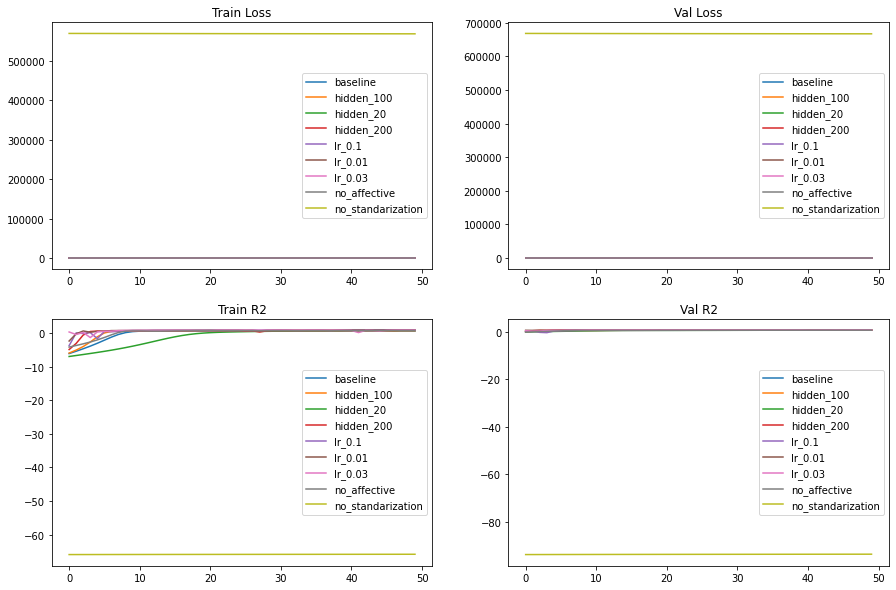

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2,2, figsize=(15,10))

for key in METRICS_24h.keys():
  ax[0][0].plot(METRICS_24h[key]['train_loss'], label=key)
  ax[0][1].plot(METRICS_24h[key]['val_loss'], label=key)
  ax[1][0].plot(METRICS_24h[key]['train_r2'], label=key)
  ax[1][1].plot(METRICS_24h[key]['val_r2'], label=key)

ax[0][0].set_title('Train Loss')
ax[0][0].legend()

ax[0][1].set_title('Val Loss')
ax[0][1].legend()

ax[1][0].set_title('Train R2')
ax[1][0].legend()

ax[1][1].set_title('Val R2')
ax[1][1].legend()
plt.legend()
plt.show()

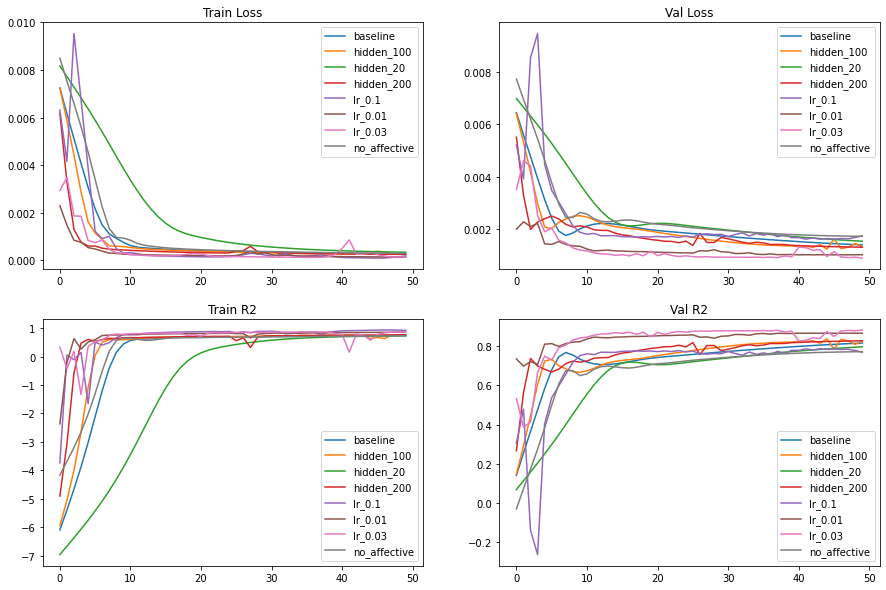

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

for key in METRICS_24h.keys():
  if key == 'no_standarization':
    continue
  ax[0][0].plot(METRICS_24h[key]['train_loss'], label=key)
  ax[0][1].plot(METRICS_24h[key]['val_loss'], label=key)
  ax[1][0].plot(METRICS_24h[key]['train_r2'], label=key)
  ax[1][1].plot(METRICS_24h[key]['val_r2'], label=key)

ax[0][0].set_title('Train Loss')
ax[0][0].legend()

ax[0][1].set_title('Val Loss')
ax[0][1].legend()

ax[1][0].set_title('Train R2')
ax[1][0].legend()

ax[1][1].set_title('Val R2')
ax[1][1].legend()
plt.legend()
plt.show()

### Bazowy model godzinny

In [ ]:
train_1h_dl = prepare_dataloader(train_1h_normed)
val_1h_dl = prepare_dataloader(val_1h_normed)
model_1h = LSTM_MODEL(11, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_1h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_1h = {}

METRICS_1h['baseline'] = fit(model= model_1h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_1h_dl, 
    val_dl = val_1h_dl, 
    epochs = 50,
    print_metrics = True)


Epoch 1: train loss = 0.001954 (r2: -2.046576), validation loss = 0.000913 (r2: -11.688915)
Epoch 2: train loss = 0.000917 (r2: 0.438080), validation loss = 0.000134 (r2: 0.346834)
Epoch 3: train loss = 0.000556 (r2: 0.501798), validation loss = 0.000066 (r2: 0.725680)
Epoch 4: train loss = 0.000423 (r2: 0.644777), validation loss = 0.000027 (r2: 0.855617)
Epoch 5: train loss = 0.000369 (r2: 0.865237), validation loss = 0.000021 (r2: 0.883697)
Epoch 6: train loss = 0.000346 (r2: 0.910806), validation loss = 0.000021 (r2: 0.899642)
Epoch 7: train loss = 0.000333 (r2: 0.921719), validation loss = 0.000019 (r2: 0.913668)
Epoch 8: train loss = 0.000320 (r2: 0.919920), validation loss = 0.000017 (r2: 0.920745)
Epoch 9: train loss = 0.000309 (r2: 0.918859), validation loss = 0.000015 (r2: 0.926525)
Epoch 10: train loss = 0.000296 (r2: 0.917597), validation loss = 0.000014 (r2: 0.929696)
Epoch 11: train loss = 0.000283 (r2: 0.919927), validation loss = 0.000013 (r2: 0.932596)
Epoch 12: train 

Badanie wpływu wielkości warstwy ukrytej

In [ ]:
model_1h = LSTM_MODEL(11, hidden_size=100, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_1h.parameters())
loss_fn = torch.nn.MSELoss()


METRICS_1h['hidden_100'] = fit(model= model_1h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_1h_dl, 
    val_dl = val_1h_dl, 
    epochs = 50,
    print_metrics = True)


Epoch 1: train loss = 0.003039 (r2: -2.648916), validation loss = 0.000169 (r2: 0.233855)
Epoch 2: train loss = 0.001246 (r2: 0.686459), validation loss = 0.000094 (r2: 0.189355)
Epoch 3: train loss = 0.001192 (r2: 0.884606), validation loss = 0.000036 (r2: 0.633328)
Epoch 4: train loss = 0.001081 (r2: 0.884294), validation loss = 0.000018 (r2: 0.844825)
Epoch 5: train loss = 0.000846 (r2: 0.903363), validation loss = 0.000016 (r2: 0.873116)
Epoch 6: train loss = 0.000687 (r2: 0.918044), validation loss = 0.000014 (r2: 0.887447)
Epoch 7: train loss = 0.000598 (r2: 0.923907), validation loss = 0.000012 (r2: 0.904543)
Epoch 8: train loss = 0.000541 (r2: 0.928464), validation loss = 0.000011 (r2: 0.922584)
Epoch 9: train loss = 0.000488 (r2: 0.928008), validation loss = 0.000011 (r2: 0.932459)
Epoch 10: train loss = 0.000442 (r2: 0.925519), validation loss = 0.000011 (r2: 0.937530)
Epoch 11: train loss = 0.000411 (r2: 0.929165), validation loss = 0.000010 (r2: 0.935304)
Epoch 12: train lo

In [ ]:
model_1h = LSTM_MODEL(11, hidden_size=20, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_1h.parameters())
loss_fn = torch.nn.MSELoss()


METRICS_1h['hidden_20'] = fit(model= model_1h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_1h_dl, 
    val_dl = val_1h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.002044 (r2: -12.533826), validation loss = 0.000250 (r2: 0.752482)
Epoch 2: train loss = 0.000887 (r2: 0.778505), validation loss = 0.000147 (r2: -1.236711)
Epoch 3: train loss = 0.000620 (r2: 0.818571), validation loss = 0.000037 (r2: 0.775403)
Epoch 4: train loss = 0.000481 (r2: 0.890154), validation loss = 0.000021 (r2: 0.899292)
Epoch 5: train loss = 0.000394 (r2: 0.845139), validation loss = 0.000022 (r2: 0.931742)
Epoch 6: train loss = 0.000337 (r2: 0.827320), validation loss = 0.000023 (r2: 0.939446)
Epoch 7: train loss = 0.000303 (r2: 0.837559), validation loss = 0.000023 (r2: 0.939049)
Epoch 8: train loss = 0.000287 (r2: 0.850890), validation loss = 0.000021 (r2: 0.938878)
Epoch 9: train loss = 0.000277 (r2: 0.853901), validation loss = 0.000020 (r2: 0.940348)
Epoch 10: train loss = 0.000268 (r2: 0.866111), validation loss = 0.000017 (r2: 0.941436)
Epoch 11: train loss = 0.000262 (r2: 0.879418), validation loss = 0.000016 (r2: 0.941860)
Epoch 12: train 

In [ ]:
model_1h = LSTM_MODEL(11, hidden_size=200, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_1h.parameters())
loss_fn = torch.nn.MSELoss()


METRICS_1h['hidden_200'] = fit(model= model_1h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_1h_dl, 
    val_dl = val_1h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.001365 (r2: 0.748980), validation loss = 0.000054 (r2: 0.896427)
Epoch 2: train loss = 0.001244 (r2: 0.793683), validation loss = 0.000068 (r2: 0.767479)
Epoch 3: train loss = 0.001095 (r2: 0.355616), validation loss = 0.000103 (r2: 0.458786)
Epoch 4: train loss = 0.000822 (r2: 0.762758), validation loss = 0.000038 (r2: 0.771749)
Epoch 5: train loss = 0.001024 (r2: 0.925174), validation loss = 0.000022 (r2: 0.885190)
Epoch 6: train loss = 0.001106 (r2: 0.894906), validation loss = 0.000013 (r2: 0.922609)
Epoch 7: train loss = 0.000715 (r2: 0.920874), validation loss = 0.000011 (r2: 0.936477)
Epoch 8: train loss = 0.000799 (r2: 0.934659), validation loss = 0.000010 (r2: 0.933621)
Epoch 9: train loss = 0.000622 (r2: 0.929281), validation loss = 0.000009 (r2: 0.933345)
Epoch 10: train loss = 0.000700 (r2: 0.938827), validation loss = 0.000009 (r2: 0.936622)
Epoch 11: train loss = 0.000565 (r2: 0.945562), validation loss = 0.000008 (r2: 0.936485)
Epoch 12: train los

In [ ]:
train_1h_raw = train_1h_normed[['open', 'high', 'low', 'close', 'volume']]
val_1h_raw = val_1h_normed[['open', 'high', 'low', 'close', 'volume']]

train_1h_raw_dl = prepare_dataloader(train_1h_raw)
val_1h_raw_dl = prepare_dataloader(val_1h_raw)
model_1h = LSTM_MODEL(4, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_1h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_1h['no_affective'] = fit(model= model_1h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_1h_raw_dl, 
    val_dl = val_1h_raw_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 0.001656 (r2: 0.683098), validation loss = 0.000091 (r2: -0.069058)
Epoch 2: train loss = 0.000857 (r2: 0.876224), validation loss = 0.000049 (r2: 0.622521)
Epoch 3: train loss = 0.000559 (r2: 0.694084), validation loss = 0.000041 (r2: 0.723314)
Epoch 4: train loss = 0.000468 (r2: 0.897182), validation loss = 0.000016 (r2: 0.876902)
Epoch 5: train loss = 0.000422 (r2: 0.907488), validation loss = 0.000015 (r2: 0.915880)
Epoch 6: train loss = 0.000394 (r2: 0.915044), validation loss = 0.000015 (r2: 0.922528)
Epoch 7: train loss = 0.000362 (r2: 0.924680), validation loss = 0.000014 (r2: 0.924954)
Epoch 8: train loss = 0.000334 (r2: 0.929163), validation loss = 0.000013 (r2: 0.926111)
Epoch 9: train loss = 0.000307 (r2: 0.933404), validation loss = 0.000012 (r2: 0.927121)
Epoch 10: train loss = 0.000285 (r2: 0.935980), validation loss = 0.000011 (r2: 0.927321)
Epoch 11: train loss = 0.000266 (r2: 0.937213), validation loss = 0.000010 (r2: 0.927140)
Epoch 12: train lo

In [ ]:
train_1h_dl = prepare_dataloader(train_1h)
val_1h_dl = prepare_dataloader(val_1h)
model_1h = LSTM_MODEL(11, hidden_size=50, num_layers=1, out_size=1, dropout=0).cuda()
optimizer = torch.optim.Adam(model_1h.parameters())
loss_fn = torch.nn.MSELoss()

METRICS_1h['no_standarization'] = fit(model= model_1h, 
    optimiser = optimizer, 
    loss_fn = loss_fn, 
    train_dl = train_1h_dl, 
    val_dl = val_1h_dl, 
    epochs = 50,
    print_metrics = True)

Epoch 1: train loss = 598853.805468 (r2: -1017.702657), validation loss = 686632.958811 (r2: -862.545511)
Epoch 2: train loss = 598561.068082 (r2: -1017.306399), validation loss = 686300.965950 (r2: -862.133946)
Epoch 3: train loss = 598261.295687 (r2: -1016.900548), validation loss = 685961.012379 (r2: -861.712438)
Epoch 4: train loss = 597958.138039 (r2: -1016.490166), validation loss = 685617.231657 (r2: -861.286242)
Epoch 5: train loss = 597667.372928 (r2: -1016.096457), validation loss = 685287.474908 (r2: -860.877380)
Epoch 6: train loss = 597381.571046 (r2: -1015.709461), validation loss = 684963.317698 (r2: -860.475508)
Epoch 7: train loss = 597098.607864 (r2: -1015.326257), validation loss = 684642.384659 (r2: -860.077590)
Epoch 8: train loss = 596817.405533 (r2: -1014.945517), validation loss = 684323.479559 (r2: -859.682247)
Epoch 9: train loss = 596537.576732 (r2: -1014.566505), validation loss = 684006.082039 (r2: -859.288715)
Epoch 10: train loss = 596258.725333 (r2: -101

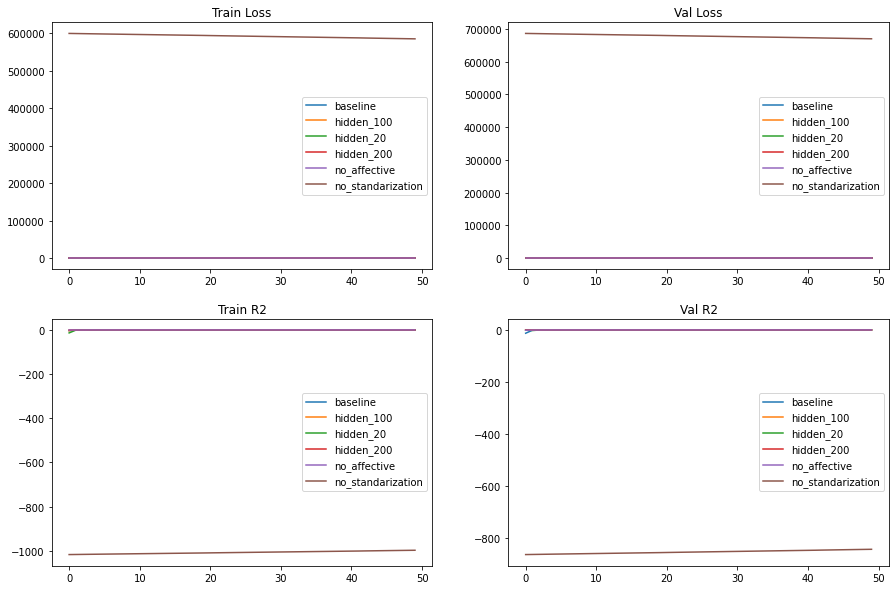

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

for key in METRICS_1h.keys():
  ax[0][0].plot(METRICS_1h[key]['train_loss'], label=key)
  ax[0][1].plot(METRICS_1h[key]['val_loss'], label=key)
  ax[1][0].plot(METRICS_1h[key]['train_r2'], label=key)
  ax[1][1].plot(METRICS_1h[key]['val_r2'], label=key)

ax[0][0].set_title('Train Loss')
ax[0][0].legend()

ax[0][1].set_title('Val Loss')
ax[0][1].legend()

ax[1][0].set_title('Train R2')
ax[1][0].legend()

ax[1][1].set_title('Val R2')
ax[1][1].legend()
plt.legend()
plt.show()

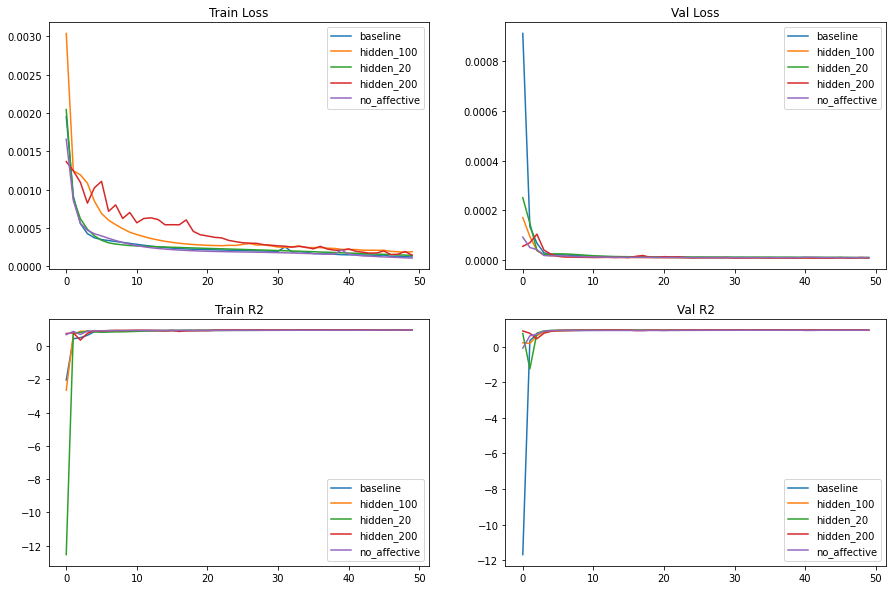

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

for key in METRICS_1h.keys():
  if key == 'no_standarization':
    continue
  ax[0][0].plot(METRICS_1h[key]['train_loss'], label=key)
  ax[0][1].plot(METRICS_1h[key]['val_loss'], label=key)
  ax[1][0].plot(METRICS_1h[key]['train_r2'], label=key)
  ax[1][1].plot(METRICS_1h[key]['val_r2'], label=key)

ax[0][0].set_title('Train Loss')
ax[0][0].legend()

ax[0][1].set_title('Val Loss')
ax[0][1].legend()

ax[1][0].set_title('Train R2')
ax[1][0].legend()

ax[1][1].set_title('Val R2')
ax[1][1].legend()
plt.legend()
plt.show()